# Tiamat - Aplicação de algoritmos genéticos a um problema de interesse científico

**Autores:** Adrian Lincoln Paz e Gabriel Viégas Ribeiro [contribuíram igualmente]

**Objetivo:**  Identifique um problema de otimização de interesse científico (este deve ser aprovado pelo professor, pode enviar uma mensagem no teams se preferir). Proponha e evolua um algoritmo genético com o propósito de resolver este problema. Utilize pelo menos um operador genético que não tenha sido apresentado no material da disciplina. Explique como este operador genético funciona na sua entrega. Se tiver interesse, pode criar seu próprio operador genético. Não se esqueça de discutir sobre o(s) resultado(s) obtido(s).

## Introdução


Modelos epidemiológicos, cujo objetivo é capturar o comportamento de uma epidemia a partir
de dados reais, mostraram ser de grande utilidade para a elaboração de estratégias de prevenção
na saúde pública, em especial na pandemia de COVID-19. Um dos modelos separa a população em
compartimentos de Suscetíveis, Infectados, Recuperados e Falecidos (SIRD, da sigla em inglês). De forma simplificada, podemos dizer que Sucetíveis corresponde a pessoas que tem a possibilidade de serem infectadas, Infectados são as pessoas que estão ativamente espalhando a doença, Recuperados são as pessoas que se recuperaram ou deixaram de ser infecciosas, e Falecidos é o cojunto que representa as pessoas que morreram. Esses compartimentos seguem o seguinte modelo de equações diferenciais:

$$
\frac{dS}{dt} = -\beta S I
$$

$$
\frac{dI}{dt} = \beta S I - \gamma I - \alpha I
$$

$$
\frac{dR}{dt} = \gamma I
$$

$$
\frac{dD}{dt} = \alpha I 
$$

Nessas equações diferenciais acopladas, $\alpha$, $\beta$ e $\gamma$ representam as taxas de morte, transmissão de infecção e recuperados. Assim, o nosso trabalho tem como objetivo minimizar a função custo entre número de casos de pessoas infectadas ($I_{real}(t)$) e o número calculado pelo modelo SIRD ($I_{calculado}(t)$) a partir de um número ótimo da taxa de infecção ($\beta$). Para isso, utilizamos os dados do site [[Coronavírus Brasil](https://covid.saude.gov.br/)], onde encontramos o número de mortos, infectados e recuperados em 2020. A função de custo  $C(\beta)$ pode ser definida como abaixo:

$$
C(\beta) = \sum_{t=0}^{n}[I_{real}(t) - I_{calculado}(t)]^2
$$

Em que "n" é o número de dias descritos pelos dados. [[Prediction of Epidemic Peak and Infected Cases for COVID-19 Disease in Malaysia, 2020](https://pmc.ncbi.nlm.nih.gov/articles/PMC7312594/pdf/ijerph-17-04076.pdf)]

Primeiramente, vamos apresentar o tratamento de dados e modelagem com o modelo SIRD (adaptado das referências [[Mastering the SEIR Model: A Comprehensive Guide with Python Code and Real-World Applications Examples](https://medium.com/pythoneers/mastering-the-seir-model-a-comprehensive-guide-with-python-code-and-real-world-applications-da7584a4fb23)] e [[Estimation of the epidemiological model with a system of
differential equations (SIRD) using the Runge-Kutta method in
Ira](https://ijnaa.semnan.ac.ir/article_6509.html)]. Em seguida, vamos otimizar o valor de $\beta$ a partir do algoritmo genético. Por último, analisaremos se o valor de beta produziu resultados coerentes com o que foi observado na literatura. 

## Resolução:

### Tratamento de dados

Primeiro, importamos as bibliotecas que foram importantes para o processo.

In [1]:
import random
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from collections.abc import Sequence, Callable

Aqui, transformaremos os dois datasets - que mostram o número de casos em 2020 no período entre 25 de fevereiro e 31 de dezembro - em um único dataset. Os dados foram obtidos a partir do [*site* oficial](https://covid.saude.gov.br/) do acompanhamento de casos da COVID-19 do governo federal.

In [2]:
dataset_1 = pd.read_csv('HIST_PAINEL_COVIDBR_2020_Parte1_12abr2025.csv', sep=';') #25 de fevereiro a 31 de julho
dataset_1_brasil = dataset_1.head(158).reset_index(drop=True)
dataset_2 = pd.read_csv( 'HIST_PAINEL_COVIDBR_2020_Parte2_12abr2025.csv', sep = ';') #01 de agosto a 31 de dezembro
dataset_2_brasil = dataset_2.head(153).reset_index(drop=True)
df_total = pd.merge(dataset_1_brasil, dataset_2_brasil, how='outer')
df_total

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
0,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-25,9,210147125.0,0,0,0,0,0.0,0.0,NaN
1,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-26,9,210147125.0,1,1,0,0,1.0,0.0,NaN
2,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-27,9,210147125.0,1,0,0,0,1.0,0.0,NaN
3,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-28,9,210147125.0,1,0,0,0,0.0,1.0,NaN
4,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-29,9,210147125.0,2,1,0,0,1.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-12-27,53,210147125.0,7484285,18479,191139,344,6475466.0,799545.0,NaN
307,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-12-28,53,210147125.0,7504833,20548,191570,431,6515370.0,777776.0,NaN
308,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-12-29,53,210147125.0,7563551,58718,192681,1111,6568898.0,744365.0,NaN
309,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-12-30,53,210147125.0,7619200,55649,193875,1194,6647538.0,723332.0,NaN


### Modelagem Matemática

Primeiramente, precisamos definir nossos parâmetros. O valor de $\alpha$, que é a taxa de mortalidade, será definida pela razão entre o número de casos pelo número de óbitos durante todo o período analisado, enquanto $\gamma$ (taxa de recuperação) será 0.1, conforme o artigo [[Prediction of Epidemic Peak and Infected Cases for COVID-19 Disease in Malaysia, 2020](https://pmc.ncbi.nlm.nih.gov/articles/PMC7312594/pdf/ijerph-17-04076.pdf)]. O valor de beta será encontrado pelo algoritmo genético posteriormente.

Além disso, temos algumas condições iniciais: o número de recuperados e mortos no tempo 0 é igual a 0, e o número de infectados é, inicialmente, igual a $\frac{1}{p \cdot N}$, em que "p" é a taxa de identificação e "N" é a população total. A taxa de identificação é calculada pela razão do número de casos confirmados pelo número de testes de COVID feitos. Assumimos que foram realizados 10 milhões de testes no período analisado, já que 5 milhões foram distribuídos entre 5 de março e 25 de julho de 2020. 

In [3]:
# Definição do M (importante posteriormente)
den_alpha = df_total['casosAcumulado'].iloc[-1]
num_alpha = df_total['obitosAcumulado'].iloc[-1]
alpha = num_alpha / den_alpha
#print(den_M)
#print(M)

# população total
N = df_total['populacaoTCU2019'][0]
p = 251701 / (10**7)

def beta_dependent_SIRD(beta, tempo=310):

    # Número inicial de infecciosos e recuperados
    I0, R0 = 1 / (p * N) , 0

    #numero inicial de mortos

    D0 = 0

    # todo o resto é sucetível

    S0 = 1 - I0 - R0 - D0

    # the contact rate, beta, incubation rate, alpha, and mean recovery rate, gamma

    gamma = 0.1

    # alpha = NÚMERO DE MORTES / NÚMERO DE CASOS

    # the time points (days) over which we want to predict using our model
    t = np.linspace(0, tempo, tempo)

    def deriv(t, y, beta, alpha, gamma):
        S, I, R, D = y
        dSdt = -beta * S  * I
        dIdt = beta * S * I  - gamma * I - alpha * I
        dRdt = gamma * I
        dDdt = alpha * I
        return dSdt,dIdt, dRdt, dDdt

    # here we set the initial conditions vector
    y0 = S0, I0, R0, D0

    # and use scipy to solve the system of differential equations
    sol = solve_ivp(deriv, [0, tempo], y0, args=(beta, alpha, gamma), t_eval=t)

    # extract the results
    S, I, R, D = sol.y

    X = p * N * I

    return S, I, R, D, X, t

Supondo um $\beta$ igual a 0.2, teríamos o seguinte comportamento:

In [4]:
S, I, R, D, X, t = beta_dependent_SIRD(0.2)

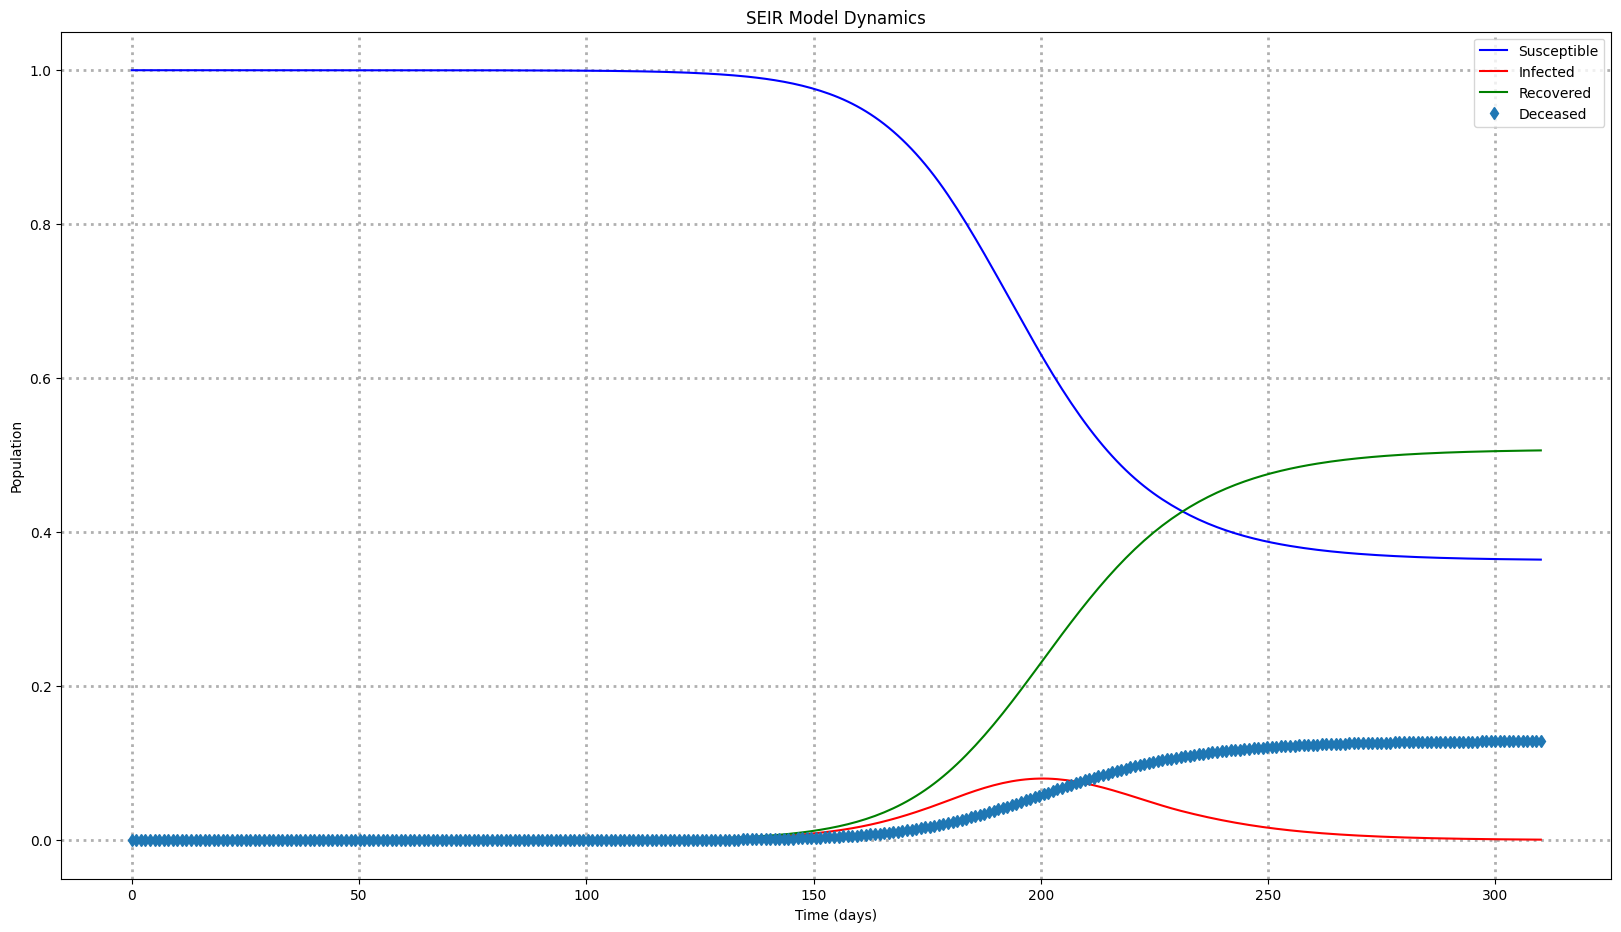

In [5]:
plt.figure(figsize=(20,11))
plt.plot(t, S, 'b', label='Susceptible')
plt.plot(t, I, 'r', label='Infected')
plt.plot(t, R, 'g', label='Recovered')
plt.plot(t, D, 'd', label='Deceased')
plt.title("SEIR Model Dynamics")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.grid(lw=2,ls=":")
plt.show()

Podemos associar os dados reais aos casos de compartimentos do modelo SIRD. Assim, teremos uma compreensão de como a epidemia se comportou nesse período. A maioria dos compartimentos é intuitivo, mas há algumas mudanças:

- "Susceptibles": representa a população suscetível. É o total da população diminuído da quantidade de Infectados, Recuperados e Falecidos.

- "Infected": representa a população *infecciosa*, ou seja, que tem capacidade de infectar. Entendendo isso, decidimos que esse compartimento seria representado pelo acumulado de casos diminuído dos casos em acompanhamento (ou seja, isolados, e portanto não mais infecciosos) e os que evoluíram a óbito.

- "Recovered": representa os recuperados. Apesar da coluna estar descrita como "Recuperadosnovos", no *site* é possível verificar que esse número é um acumulado de casos.

- "Deceased": representa o acumulado de óbitos.

In [6]:
# Pegando apenas os dados relevantes e tratando os dados
df_SIRD = pd.DataFrame({})

# define o número de recuperados
df_SIRD["Recovered"] = df_total["Recuperadosnovos"].copy()

#define o número de falecidos
df_SIRD["Deceased"] = df_total["obitosAcumulado"].copy()

# define o número de infectados infecciosos
df_SIRD["Infected"] = df_total["casosAcumulado"].copy() - df_total['emAcompanhamentoNovos'] - df_total['obitosNovos']

#define o número de sucetíveis
df_SIRD["Susceptibles"] = df_total["populacaoTCU2019"] - df_SIRD["Infected"] - df_SIRD["Recovered"] - df_SIRD["Deceased"]

Dessa forma, podemos plotar o gráfico com cada um dos compartimentos. Como o número de suscetíveis é muito alto, podemos retirar esse compartimento para facilitar a visualização dos outros componentes, como é visto no gráfico à direita abaixo.

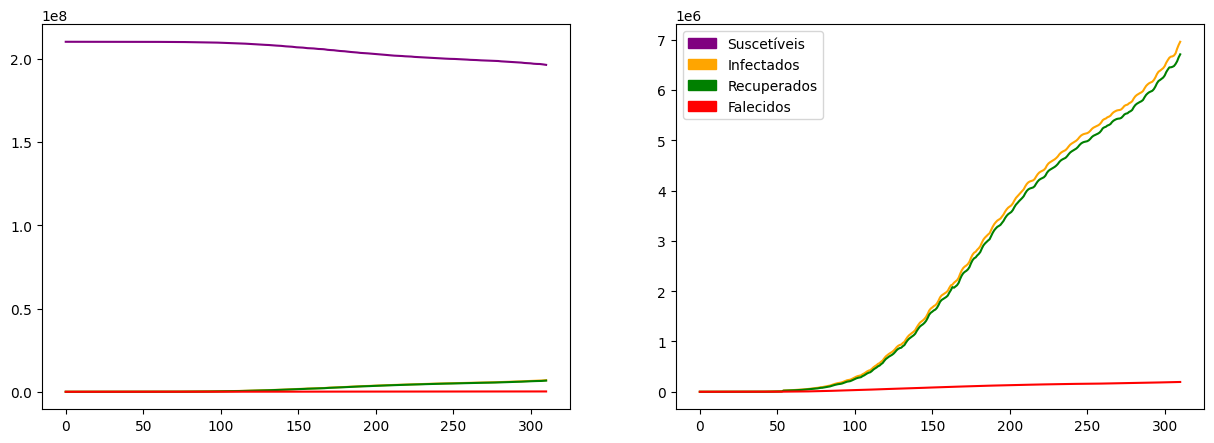

In [7]:
import matplotlib.patches as mpatches
#normalization = df_SIRD / df_SIRD.max()
#normalization.plot()
df_novo = df_SIRD.drop(columns='Susceptibles')

legend_elements = [
    mpatches.Patch(color='purple', label='Suscetíveis'),
    mpatches.Patch(color='orange', label='Infectados'),
    mpatches.Patch(color='green', label='Recuperados'),
    mpatches.Patch(color='red', label='Falecidos')
]


fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(df_SIRD['Susceptibles'], color='purple')
ax[0].plot(df_SIRD['Infected'], color='orange')
ax[0].plot(df_SIRD['Recovered'], color='green')
ax[0].plot(df_SIRD['Deceased'], color='red')

ax[1].plot(df_SIRD['Infected'], color='orange')
ax[1].plot(df_SIRD['Recovered'], color='green')
ax[1].plot(df_SIRD['Deceased'], color='red')

plt.legend(handles=legend_elements);

É possível perceber que o número de Infectados e Recuperados estava crescendo a um ritmo similar e com formato de "sino", característico do início da curva do modelo SIRD.

### Algoritmo genético

Vamos definir as funções necessárias para o algoritmo genético. Nossa linha de trabalho se baseará nas funções performadas pelo algoritmo do MATLAB. [[Genetic Algorithm](https://www.mathworks.com/help/gads/genetic-algorithm.html), [Genetic Algorithm Options](https://www.mathworks.com/help/gads/genetic-algorithm-options.html), [How the Genetic Algorithm Works](https://www.mathworks.com/help/gads/how-the-genetic-algorithm-works.html)]

**Função custo:**
Nossa função objetivo; neste problema desejamos que ela seja a menor possível. A função custo, apresentada anteriormente, representa a média da diferença diária entre os valores diários reais do acumulado de pessoas infectadas (representado por `df_SIRD['Infected']`) e os valores diários previstos pelo modelo SIRD (compartimento I multiplicado por pN (definido acima), ou seja, X).

$$
C(\beta) = \sum_{t=0}^{n}[X_{dado}(t) - X_{calculado}(t)]^2
$$

In [8]:
def obj_function_infection_rate(infected_data: Sequence[float], beta: float, compute_infection: Callable[[float], Sequence[float]]) -> Sequence[float]:
    """Calcula a função custo entre o valor real de infectados e o valor calculado."""
    
    infected_calculated = compute_infection(beta)
    
    # Esse bloco garante que ambas listas/arrays tenham o mesmo tamanho
    try:
        infected_data = infected_data[:len(infected_calculated)]
    except:
        infected_calculated = infected_calculated[:len(infected_data)]
    
    fitness_raw = (infected_data - infected_calculated) ** 2
    fitness = np.mean(fitness_raw) # calcula o fitness médio para esse beta

    return fitness

def pop_obj_function_infection_rate(infected_data: Sequence[float], beta_list: Sequence[float], compute_infection: Callable[[float], float]) -> Sequence[float]:
    
    # Calcula o valor de fitness da população
    fitness = []
    for beta in beta_list:
        fitness.append(obj_function_infection_rate(infected_data, beta, compute_infection))

    return fitness

**Função de criação da população inicial:**

A partir das funções SEIRD definidas anteriormente, cria indivíduos para a população igualmente espaçados respeitando os limites de valores de $\beta$. é baseada na função original do MATLAB `gacreationlinearfeasible`.

In [9]:
def initial_population(beta_range: Sequence[float, float], number_of_individuals=200) -> Sequence[float]:

    return np.linspace(beta_range[0], beta_range[1], num=number_of_individuals)

**Seleção por [*Stochastic Universal Sampling (SUS)*](https://en.wikipedia.org/wiki/Stochastic_universal_sampling) adaptada para minimização:**

É uma adaptação da função roleta de seleção proporcional ao "*fitness*", mas que não apresenta viés e permite que indivíduos com menor aptidão tenham a chance de serem selecionados também. É possível imaginá-la como uma estrada de terrenos, em que o tamanho do terreno indica a aptidão do indivíduo (ver imagem abaixo), ou seja, terrenos maiores indicam indivíduos mais aptos.

![img](https://upload.wikimedia.org/wikipedia/commons/b/b7/Statistically_Uniform.png)

O algoritmo irá escolher um ponto de partida aleatório, com valor máximo sendo o valor total de fitness divido pelo número de indivíduos. A partir desse ponto, o algoritmo "caminha" na estrada do fitness quantidades equidistantes até conseguir a quantidade de amostras suficientes. Isso garante uma distribuição mais equilibrada e justa das escolhas.

Perceba que esse tipo de seleção seria mais adequada para situações de maximização, uma vez que os maiores valores têm tamanho maior. Nesse caso, o que fizemos para adaptar foi definir o "fitness ajustado" para o inverso do fitness real, garantindo que mínimos tenham maior "terreno".

In [10]:
def SUS(initial_pop: Sequence[float], fitness: Sequence[float], survivors = None) -> Sequence[float]:

    # Quantidade de sobreviventes da população. O valor padrão é o tamanho da população inicial
    if survivors == None:
        survivors = len(initial_pop)

    # Distância entre os ponteiros (fitness ajustado / número de sobreviventes)
    fitness_adjusted = np.array(fitness) ** (-1)
    pointers_distance = sum(fitness_adjusted) / survivors

    # Ponteiros
    point = random.uniform(0, pointers_distance)
    pointers = [point * i for i in range(0, survivors)]
    
    # Seleção de fato
    selected = []
    fitness_sorted = sorted(fitness_adjusted)

    for p in pointers:
        i = 0
        while sum(fitness_sorted[:i+1]) < p:
            i += 1
        selected.append(initial_pop[i])

    return selected

**Crossover por "crossover intermediário":**

Técnica utilizada no MATLAB (`crossoverintermediate`), faz a reprodução a partir da combinação linear dos pais.

In [11]:
def intermediate_crossover(parent1: float, parent2: float, ratio=1) -> float:
    return parent1 + random.random() * ratio * (parent2 - parent1), parent2 + random.random() * ratio * (parent1 - parent2)

**Mutação adaptativa:**

Leva em consideração a efetividade das mutações anteriores (levando em consideração o aumento ou não do *fitness* da geração anterior) para definir o passo de mutação e a direção.

Na nossa [referência](https://pmc.ncbi.nlm.nih.gov/articles/PMC7312594/pdf/ijerph-17-04076.pdf), há o uso de dois percentuais: o "mutation rate", que seria a chance individual de cada gene em um indivíduo mutar, e o "mutation percentage", que se refere a porcentagem de indivíduos de uma população que estarão aptos a mutar. O comportamento estocástico dessa escolha gênica em duas etapas é diferente de apenas definir a porcentagem de indivíduos por geração a serem mutados para 1,8%, de maneira que seguiremos essa lógica em nosso algoritmo. Teremos, portanto, dois momentos de escolha da mutação do indivíduo.

In [12]:
def individual_adaptive_mutation(mutable_individual: float, bounds: Sequence[float, float], step_size: float, mutation_chance: float) -> float:

    if random.random() > mutation_chance:
        return mutable_individual

    # Define a direção da mutação, ou seja, se ela será positiva ou negativa
    direction = random.choice((-1,1))

    # Muta o indivíduo
    mutable_individual = mutable_individual + mutable_individual * direction * step_size

    # Verifica se está dentro do confinamento
    mutable_individual = min([max([bounds[0], mutable_individual]), bounds[1]])

    return mutable_individual

def pop_adaptive_mutation(population: Sequence[float], fitness_function: Callable[[Sequence[float]], Sequence[float]], fitness_raw: Sequence[float],
                          mutation_rate: float, mutation_chance,
                          bounds: float, step_size: float):

    # Cria uma cópia da lista original
    new_population = population.copy()

    # Submete uma parcela da população à chance de mutação
    for index_pop in range(len(new_population)):
        if random.random() > mutation_rate:
            continue # se o número for mais alto que a chance de mutação, não acontece nada

        # se não for, haverá chance de mutação
        new_population[index_pop] = individual_adaptive_mutation(new_population[index_pop], bounds, step_size, mutation_chance)

    # Ajuste do tamanho do passo

    ## pela média e pela quantidade de sucessos
    new_fitness = fitness_function(new_population)
    
    successes = 0
    for old_fit, new_fit in zip(fitness_raw, new_fitness):
        if old_fit > new_fit:
            successes += 1
    success_rate = successes / len(new_fitness)
    
    if success_rate < 0.2 or np.mean(fitness_raw) > np.mean(new_fitness):
        step_size *= 0.95
    else:
        step_size *= 1.05

    return new_population, new_fitness, step_size

Feito isso, podemos executar nosso algoritmo genético. Vamos definir o tamanho da população em 200 e iterar 1000 vezes. As porcentagens de crossover e mutação serão 95%, com uma taxa de mutação de 2%. Além disso, o $\beta$ será um valor entre 0.05 e 0.25, pensado a partir do fato de que os dados representam o início da pandemia, e definiremos o tamanho do passo da mutação como 0.1.

In [13]:
# parâmetros do algortimo
POPULATION_SIZE = 200
NUMBER_OF_ITERATIONS = 1000
CROSSOVER_PERCENTAGE = 0.95
MUTATION_RATE = 0.02
MUTATION_PERCENTAGE = 0.95

# limites do beta
BOUNDS = (0.05, 0.25)
step_size = 0.1

# Funções auxiliares
funcao_auxiliar = lambda beta: beta_dependent_SIRD(beta)[4] # X_calculado para cada beta
X_real = df_SIRD['Infected']

Estabelecidos todos os parâmetros e funções necessárias, podemos executar o algoritmo genético. Utilizamos o np.mean() para extrairmos a média da lista com os valores de erro quadrático por dia (fitness). Assim, podemos trabalhar com um fitness numérico, e não com listas.

In [14]:
population = initial_population(beta_range=BOUNDS, number_of_individuals=200)
elite = []

for n in range(NUMBER_OF_ITERATIONS):
    fitness_func = lambda x: pop_obj_function_infection_rate(infected_data=X_real, beta_list=x, compute_infection=funcao_auxiliar)
    
    # Seleção
    fitness = fitness_func(population)
    selected = SUS(initial_pop=population, fitness=fitness)

    # Cruzamento
    next_generation = []
    for parent1, parent2 in zip(selected[::2], selected[1::2]):
        if random.random() < CROSSOVER_PERCENTAGE:
            child1, child2 = intermediate_crossover(parent1, parent2)
        else:
            child1, child2 = parent1, parent2
        next_generation.append(child1)
        next_generation.append(child2)

    # Mutação
    population, fitness, step_size = pop_adaptive_mutation(population=population, fitness_function=fitness_func, fitness_raw=fitness,
                          mutation_rate=MUTATION_RATE, mutation_chance=MUTATION_PERCENTAGE, bounds=BOUNDS, step_size=step_size)

    # Atualização do hall da fama
    maior_fitness = min(fitness) # por ser um problema de minimização
    ind = fitness.index(maior_fitness)
    elite.append(next_generation[ind])
    print(n, next_generation[ind])

    # Encerramento
    populacao = next_generation

0 0.16097408948309844
1 0.0924092731508166
2 0.05
3 0.1441988061767885
4 0.11231155778894474
5 0.1525014406196266
6 0.17805146913598568
7 0.1564623318694893
8 0.1447164625759547
9 0.06743121859296483
10 0.16391468582840826
11 0.16256281407035178
12 0.08816494304614546
13 0.16825412411065183
14 0.07512562814070352
15 0.1394217720604174
16 0.1208714983642165
17 0.14566456179928597
18 0.15971371908746648
19 0.1583796241736925
20 0.13617801954405295
21 0.16101790621131273
22 0.09536975642291728
23 0.11934673366834171
24 0.15892198574065775
25 0.06127331900994466
26 0.12007537688442213
27 0.1598581402362965
28 0.15373920666738036
29 0.1331366345091667
30 0.16385356000630596
31 0.06507537688442211
32 0.11515296954902049
33 0.05441212914402693
34 0.121356783919598
35 0.14396118356413506
36 0.16650986848534227
37 0.1440964342297272
38 0.13254587038898405
39 0.1694710910495862
40 0.09928826033507948
41 0.1163316582914573
42 0.14553839525729836
43 0.1229490226480889
44 0.16751103440877874
45 0.1

Desses valores, escolheremos os $\beta$ com melhor fitness. Em seguida, mostraremos o comportamento das funções para cada um desses valores escolhidos.

In [21]:
fit = fitness_func(elite)
sorted_fit = sorted(fit)[:3]
best = []
for i in sorted_fit:
    j = fit.index(i)
    best.append(elite[j])
print(rf'Três melhores valores de $\beta$: {best}')

Três melhores valores de $\beta$: [np.float64(0.18524408638434287), np.float64(0.18646893314481253), np.float64(0.1843686305601232)]


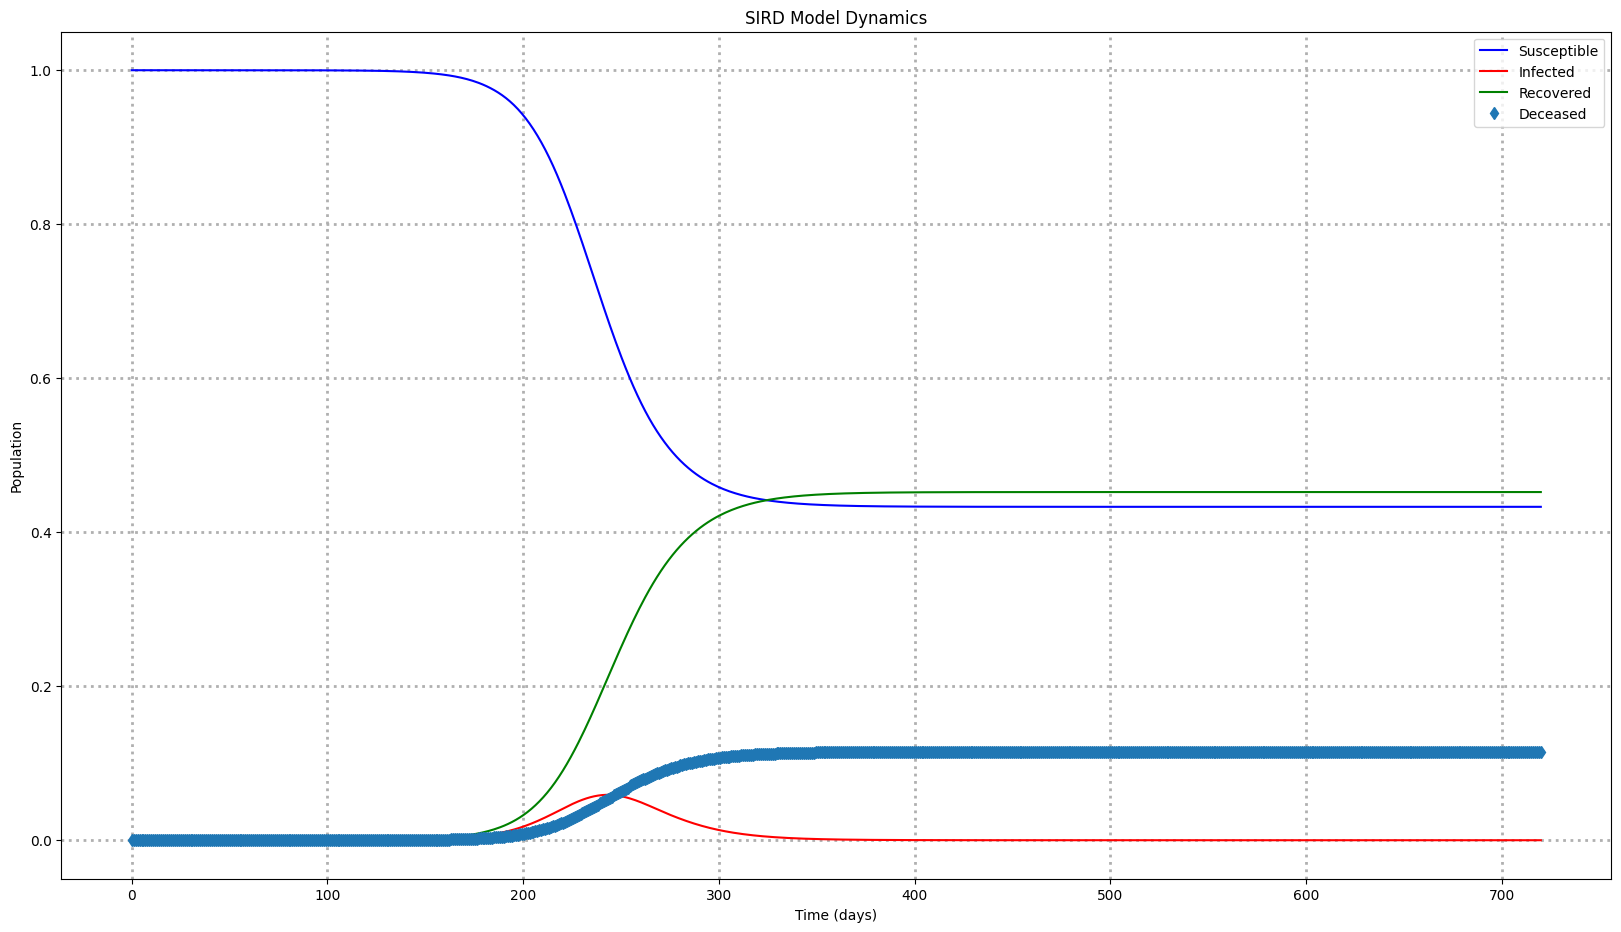

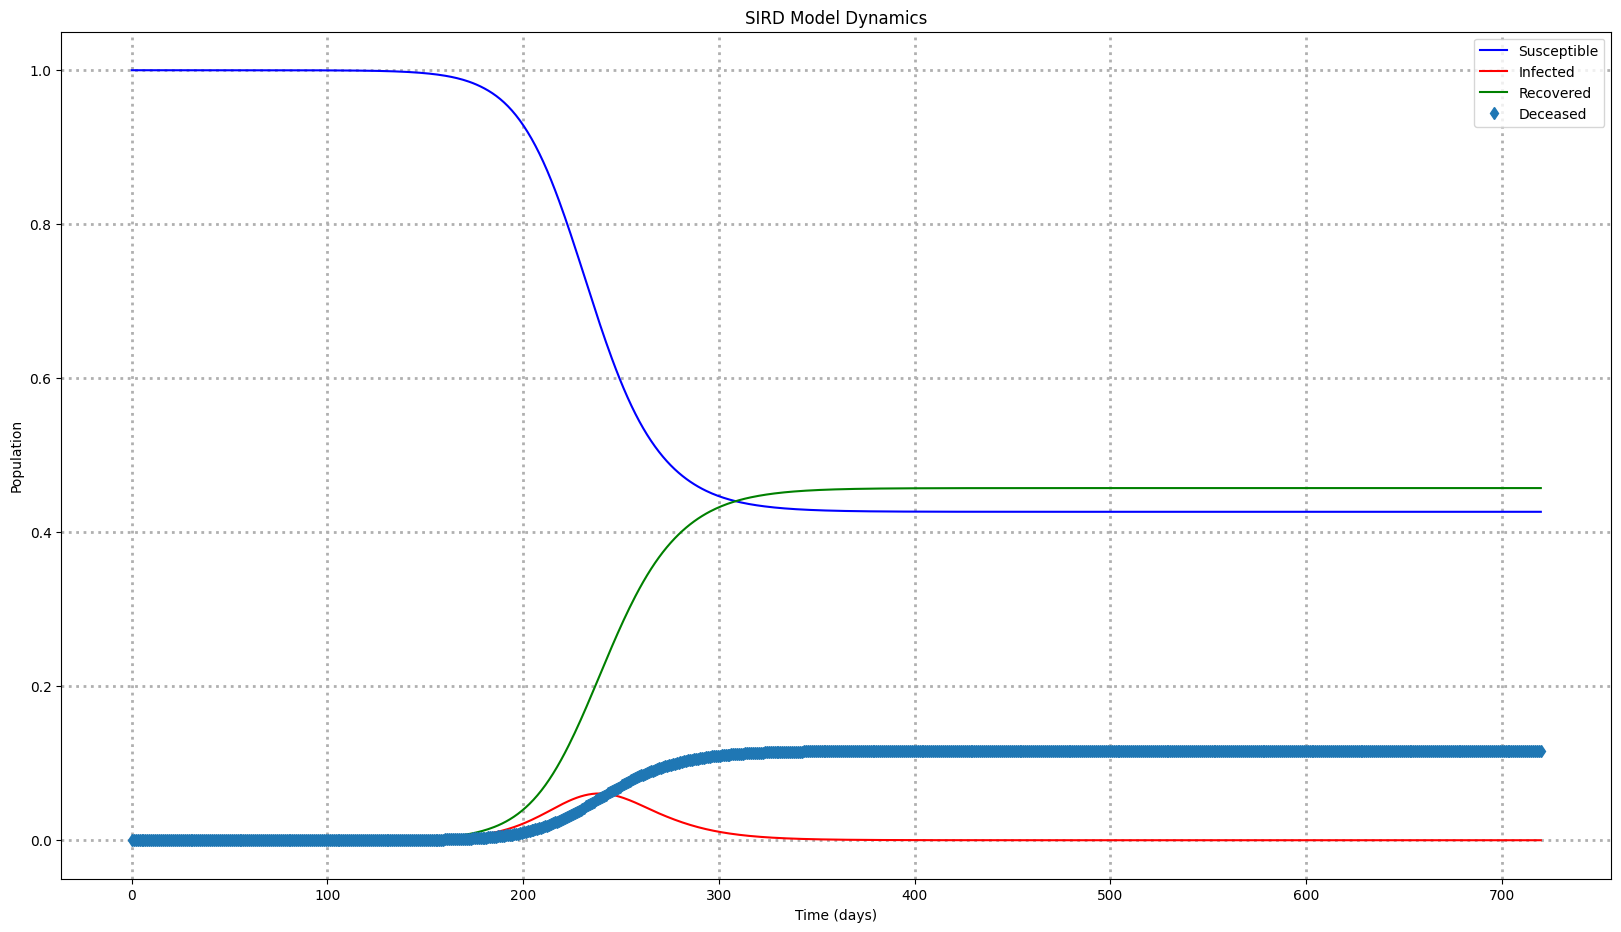

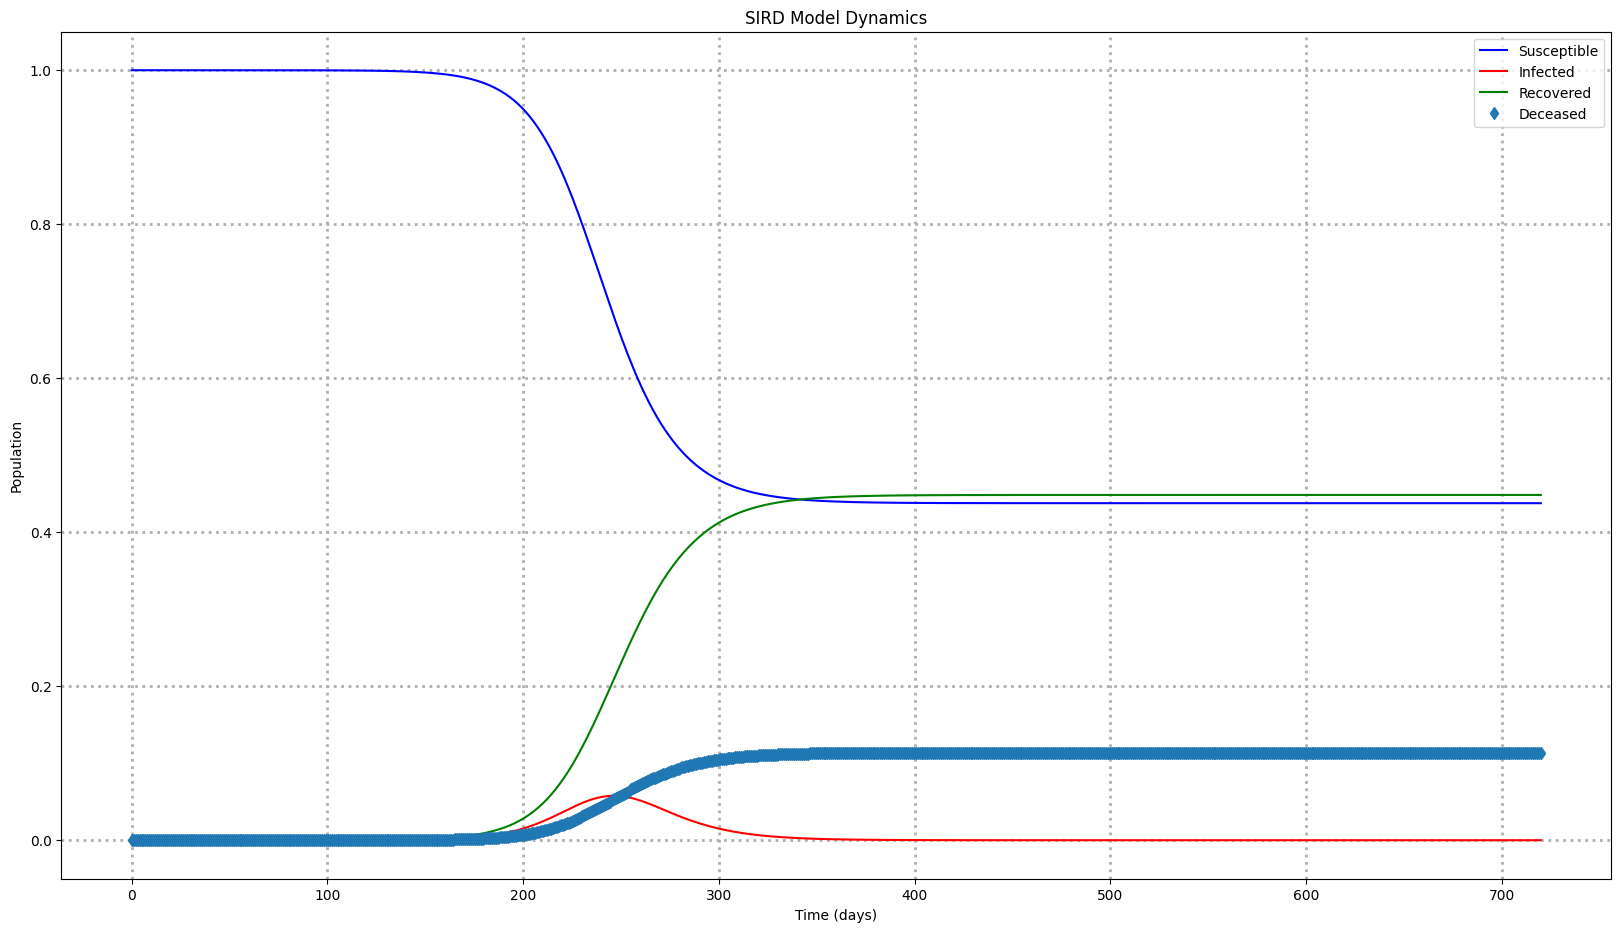

In [22]:
for i in best:
    S, I, R, D, X, t = beta_dependent_SIRD(i, tempo=720)
    plt.figure(figsize=(20,11))
    plt.plot(t, S, 'b', label='Susceptible')
    plt.plot(t, I, 'r', label='Infected')
    plt.plot(t, R, 'g', label='Recovered')
    plt.plot(t, D, 'd', label='Deceased')
    plt.title("SIRD Model Dynamics")
    plt.xlabel("Time (days)")
    plt.ylabel("Population")
    plt.legend()
    plt.grid(lw=2,ls=":")
    plt.show()

### Resultados

Não conseguimos fazer uma modelagem que corresponda ao comportamento real da pandemia. O pico da pandemia ocorreu em março de 2021, ou seja, o pico do número de infectados da nossa modelagem deveria ocorrer entre 300 e 400 dias após o início do período analisado (25 de fevereiro). Com os valores de $\beta$ encontrados, tivemos um pico entre 200 e 300 dias após o início do período.

## Conclusão

Apesar dos resultados insatisfatórios, conseguimos aplicar o algoritmo genético com o intuito de resolver um problema de interesse científico. Além disso, conseguimos criar operadores que não foram apresentados em sala de aula. Acreditamos que alterações na modelagem e um melhor entendimento de como compartimentalizar os dados reais podem contribuir para um resultado mais preciso. 